In [75]:
# Import libraries
import os
os.chdir("/Users/dimitrismarkopoulos/Desktop/regime-detection")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt ; import matplotlib as mpl ; from matplotlib.colors import ListedColormap ; import matplotlib.cm as cm
import seaborn as sns ; sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.utils import resample

import umap

# Define Globs
media_path = "docs/media/"

In [2]:
# Load Data
df = pd.read_excel("data.xlsx",index_col=0)
df = df.replace(0, 1e-6)

In [ ]:
def preprocess_data(df, method):
    if method == "raw":
        return df
    
    elif method == "diff_zscore":
        x = df.diff()
        return ((x - x.mean()) / x.std()).dropna()
    
    elif method == "returns":
        return np.log(df / df.shift(1)).dropna()

    else:
        raise ValueError(f"Unknown preprocessing method: {method}")
    
def reduce_dimension(X, method, **kwargs):

    if method == "pca":
        return PCA(
            n_components=kwargs["n_components"]
        ).fit_transform(X)

    elif method == "umap":
        return umap.UMAP(
            n_components=kwargs["n_components"],
            n_neighbors=kwargs["n_neighbors"],
            min_dist=kwargs["min_dist"],
            random_state=0
        ).fit_transform(X)

    elif method == "tsne":
        return TSNE(
            n_components=kwargs["n_components"],
            perplexity=kwargs["perplexity"],
            learning_rate="auto",
            init="pca",
            random_state=0
        ).fit_transform(X)

    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")

def cluster_data(Z, method, k):

    if method == "kmeans":
        return KMeans(
            n_clusters=k,
            n_init=20,
            random_state=0
        ).fit_predict(Z)

    elif method == "gmm":
        return GaussianMixture(
            n_components=k,
            random_state=0
        ).fit_predict(Z)

    elif method == "hierarchical":
        return AgglomerativeClustering(
            n_clusters=k,
            linkage="ward"
        ).fit_predict(Z)

    else:
        raise ValueError(f"Unknown clustering method: {method}")

def stability_score(Z, cluster_method, k, n_bootstrap=25, sample_frac=0.8):
    labels_full = cluster_data(Z, cluster_method, k)
    ari_scores = []

    for _ in range(n_bootstrap):
        idx = resample(
            np.arange(len(Z)),
            replace=False,
            n_samples=int(sample_frac * len(Z))
        )
        
        labels_sub = cluster_data(Z[idx], cluster_method, k)
        ari = adjusted_rand_score(labels_full[idx], labels_sub)
        ari_scores.append(ari)

    return np.mean(ari_scores)

In [4]:
results = []

preprocessing_methods = ["raw", "diff_zscore", "returns"]
cluster_methods = ["kmeans", "gmm", "hierarchical"]
k_list = [3, 4, 5]

for prep in preprocessing_methods:
    X = preprocess_data(df, prep)

    # ---------- PCA ----------
    for n_comp in [2, 3, 5, 10]:
        Z = reduce_dimension(
            X.values,
            method="pca",
            n_components=n_comp
        )

        for cluster in cluster_methods:
            for k in k_list:
                labels = cluster_data(Z, cluster, k)
                sil = silhouette_score(Z, labels)
                stab = stability_score(Z, cluster, k)

                results.append({
                    "preprocessing": prep,
                    "dimred": "pca",
                    "n_components": n_comp,
                    "n_neighbors": None,
                    "min_dist": None,
                    "perplexity": None,
                    "clustering": cluster,
                    "k": k,
                    "silhouette": sil,
                    "stability_ari": stab
                })

    # ---------- UMAP ----------
    for n_comp in [2, 3, 5]:
        for nn in [5, 15, 30]:
            for md in [0.0, 0.1, 0.5]:

                Z = reduce_dimension(
                    X.values,
                    method="umap",
                    n_components=n_comp,
                    n_neighbors=nn,
                    min_dist=md
                )

                for cluster in cluster_methods:
                    for k in k_list:
                        labels = cluster_data(Z, cluster, k)
                        sil = silhouette_score(Z, labels)
                        stab = stability_score(Z, cluster, k)

                        results.append({
                            "preprocessing": prep,
                            "dimred": "umap",
                            "n_components": n_comp,
                            "n_neighbors": nn,
                            "min_dist": md,
                            "perplexity": None,
                            "clustering": cluster,
                            "k": k,
                            "silhouette": sil,
                            "stability_ari": stab
                        })

    # ---------- t-SNE ----------
    for n_comp in [2, 3]:
        for p in [10, 30, 50]:

            Z = reduce_dimension(
                X.values,
                method="tsne",
                n_components=n_comp,
                perplexity=p
            )

            for cluster in cluster_methods:
                for k in k_list:
                    labels = cluster_data(Z, cluster, k)
                    sil = silhouette_score(Z, labels)
                    stab = stability_score(Z, cluster, k)

                    results.append({
                        "preprocessing": prep,
                        "dimred": "tsne",
                        "n_components": n_comp,
                        "n_neighbors": None,
                        "min_dist": None,
                        "perplexity": p,
                        "clustering": cluster,
                        "k": k,
                        "silhouette": sil,
                        "stability_ari": stab
                    })

results_df = pd.DataFrame(results)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: 

In [7]:
results_df.to_csv("results.csv")

In [9]:
df = results_df.copy()

df["sil_norm"] = (
    df["silhouette"] - df["silhouette"].min()
) / (
    df["silhouette"].max() - df["silhouette"].min()
)

df["stab_norm"] = (
    df["stability_ari"] - df["stability_ari"].min()
) / (
    df["stability_ari"].max() - df["stability_ari"].min()
)

df["score"] = 0.5 * df["sil_norm"] + 0.5 * df["stab_norm"]

df.sort_values("score", ascending=False).head(40)

,preprocessing,dimred,n_components,n_neighbors,min_dist,perplexity,clustering,k,silhouette,stability_ari,sil_norm,stab_norm,score
672,returns,pca,2,NaN,NaN,NaN,hierarchical,3,0.945839,1.000000,1.000000,1.000000,1.000000
666,returns,pca,2,NaN,NaN,NaN,kmeans,3,0.945839,1.000000,1.000000,1.000000,1.000000
675,returns,pca,3,NaN,NaN,NaN,kmeans,3,0.933943,1.000000,0.987706,1.000000,0.993853
681,returns,pca,3,NaN,NaN,NaN,hierarchical,3,0.933943,1.000000,0.987706,1.000000,0.993853
684,returns,pca,5,NaN,NaN,NaN,kmeans,3,0.921019,1.000000,0.974351,1.000000,0.987175
690,returns,pca,5,NaN,NaN,NaN,hierarchical,3,0.921019,1.000000,0.974351,1.000000,0.987175
699,returns,pca,10,NaN,NaN,NaN,hierarchical,3,0.912272,1.000000,0.965311,1.000000,0.982656
693,returns,pca,10,NaN,NaN,NaN,kmeans,3,0.912272,1.000000,0.965311,1.000000,0.982656
668,returns,pca,2,NaN,NaN,NaN,kmeans,5,0.685452,0.970674,0.730910,0.969171,0.850040
667,returns,pca,2,NaN,NaN,NaN,kmeans,4,0.705754,0.924691,0.751890,0.920829,0.836360


In [63]:
df.sort_values("score", ascending=False).head(5)[["preprocessing","dimred", "clustering", "k", "silhouette", "stability_ari","score"]]

,preprocessing,dimred,clustering,k,silhouette,stability_ari,score
672,returns,pca,hierarchical,3,0.945839,1.0,1.000000
666,returns,pca,kmeans,3,0.945839,1.0,1.000000
675,returns,pca,kmeans,3,0.933943,1.0,0.993853
681,returns,pca,hierarchical,3,0.933943,1.0,0.993853
684,returns,pca,kmeans,3,0.921019,1.0,0.987175


In [24]:
df.groupby("dimred").max()

,preprocessing,n_components,n_neighbors,min_dist,perplexity,clustering,k,silhouette,stability_ari,sil_norm,stab_norm,score
dimred,,,,,,,,,,,,
pca,returns,10,NaN,NaN,NaN,kmeans,5,0.945839,1.0,1.000000,1.0,1.000000
tsne,returns,3,NaN,NaN,50.0,kmeans,5,0.409477,1.0,0.445710,1.0,0.716638
umap,returns,5,30.0,0.5,NaN,kmeans,5,0.763393,1.0,0.811456,1.0,0.764429


In [55]:
top3_per_prep_dimred = (
    df
    .sort_values("score", ascending=False)
    .groupby(["preprocessing", "dimred"], group_keys=False)
    .head(1)
)

top3_per_prep_dimred.sort_values(by=["preprocessing","dimred"])


,preprocessing,dimred,n_components,n_neighbors,min_dist,perplexity,clustering,k,silhouette,stability_ari,sil_norm,stab_norm,score
333,diff_zscore,pca,2,NaN,NaN,NaN,kmeans,3,0.316725,0.958296,0.349858,0.956157,0.653008
632,diff_zscore,tsne,2,NaN,NaN,50.0,kmeans,5,0.385862,0.980342,0.421306,0.979334,0.700320
398,diff_zscore,umap,2,15.0,0.0,NaN,kmeans,5,0.394941,0.988587,0.430689,0.988002,0.709345
2,raw,pca,2,NaN,NaN,NaN,kmeans,5,0.544998,0.999222,0.585761,0.999183,0.792472
303,raw,tsne,2,NaN,NaN,50.0,hierarchical,3,0.397444,1.000000,0.433275,1.000000,0.716638
173,raw,umap,3,30.0,0.0,NaN,kmeans,5,0.490557,0.999389,0.529500,0.999358,0.764429
672,returns,pca,2,NaN,NaN,NaN,hierarchical,3,0.945839,1.000000,1.000000,1.000000,1.000000
964,returns,tsne,2,NaN,NaN,50.0,kmeans,4,0.399784,0.981365,0.435693,0.980409,0.708051
756,returns,umap,2,30.0,0.0,NaN,kmeans,3,0.359715,0.995013,0.394286,0.994757,0.694521


In [57]:
top3_per_prep_dimred.sort_values(by=["score"],ascending=False)[["preprocessing","dimred","k","silhouette","stability_ari","score"]]

,preprocessing,dimred,k,silhouette,stability_ari,score
672,returns,pca,3,0.945839,1.000000,1.000000
2,raw,pca,5,0.544998,0.999222,0.792472
173,raw,umap,5,0.490557,0.999389,0.764429
303,raw,tsne,3,0.397444,1.000000,0.716638
398,diff_zscore,umap,5,0.394941,0.988587,0.709345
964,returns,tsne,4,0.399784,0.981365,0.708051
632,diff_zscore,tsne,5,0.385862,0.980342,0.700320
756,returns,umap,3,0.359715,0.995013,0.694521
333,diff_zscore,pca,3,0.316725,0.958296,0.653008


## Viz

In [ ]:
# Global plotting style 
mpl.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.dpi": 300,
})

# Colorblind-safe, muted palette
cluster_cmap = ListedColormap([
    "#4C72B0",  # blue
    "#DD8452",  # orange
    "#55A868",  # green
    "#C44E52",  # red
    "#8172B2",  # purple
    "#64B5CD",  # cyan
    "#937860",  # brown
    "#DA8BC3",  # pink
])

In [ ]:
# Load raw data
df_raw = pd.read_excel("data.xlsx", index_col=0)
df_raw = df_raw.replace(0, 1e-6)
df_raw = df_raw.apply(pd.to_numeric, errors="coerce").dropna()

# Select best configuration per
# (preprocessing × dimred)
best_configs = (
    df
    .sort_values("score", ascending=False)
    .groupby(["preprocessing", "dimred"], group_keys=False)
    .head(1)
)

# Cache best configuration
cached_embeddings = []

for _, row in best_configs.iterrows():

    X = preprocess_data(df_raw, row["preprocessing"])

    Z = reduce_dimension(
        X.values,
        method=row["dimred"],
        n_components=row["n_components"],
        n_neighbors=row["n_neighbors"],
        min_dist=row["min_dist"],
        perplexity=row["perplexity"]
    )

    labels = cluster_data(Z, row["clustering"], row["k"])

    emb_df = pd.DataFrame({
        "x": Z[:, 0],
        "y": Z[:, 1],
        "label": labels,
        "date": X.index,
        "preprocessing": row["preprocessing"],
        "dimred": row["dimred"],
        "k": row["k"],
        "silhouette": row["silhouette"],
        "stability_ari": row["stability_ari"]
    })

    cached_embeddings.append(emb_df)

cached_embeddings_df = pd.concat(cached_embeddings, ignore_index=True)

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for para

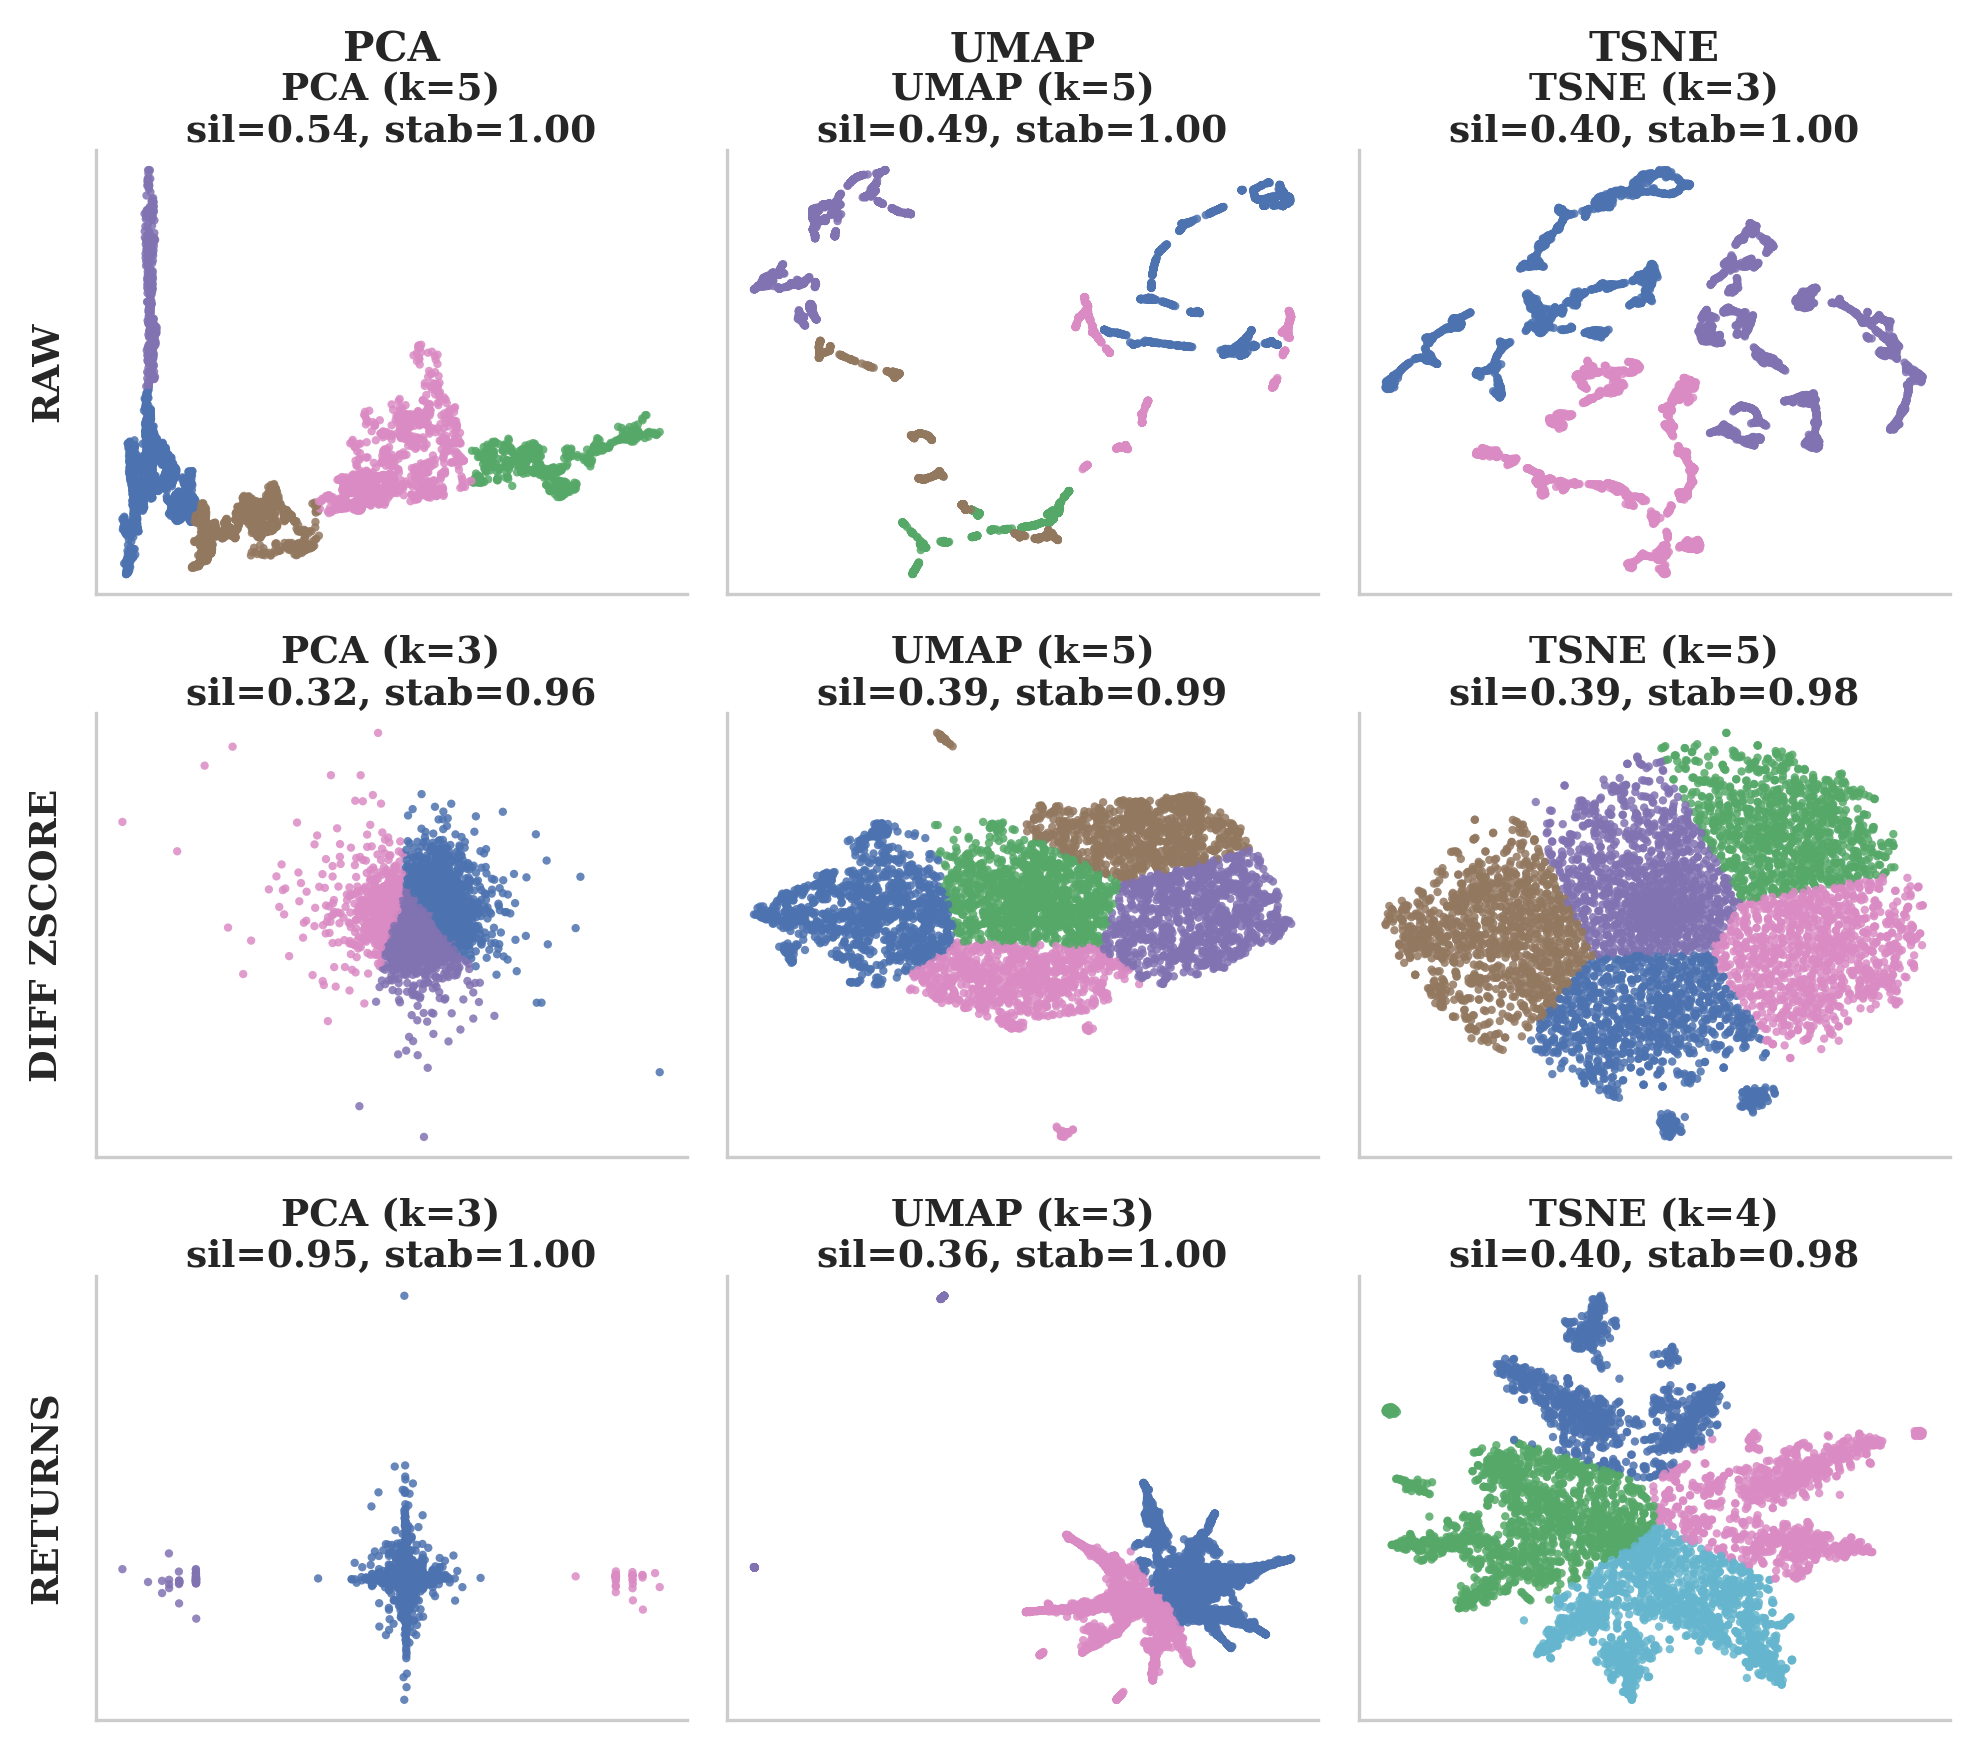

In [ ]:
def plot_embedding_cached(ax, df_sub, meta_row):
    ax.scatter(
        df_sub["x"],
        df_sub["y"],
        c=df_sub["label"],
        s=4,
        alpha=0.85,
        cmap=cluster_cmap,
        linewidths=0
    )

    # Title
    ax.set_title(
        f"{meta_row['dimred'].upper()} (k={meta_row['k']})\n"
        f"sil={meta_row['silhouette']:.2f}, stab={meta_row['stability_ari']:.2f}",
        pad=2,
        fontweight="bold",
        fontsize=9
    )

    ax.set_xticks([])
    ax.set_yticks([])

preprocessing_methods = ["raw", "diff_zscore", "returns"]
dimred_order = ["pca", "umap", "tsne"]

fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(7.0, 6.2),
    constrained_layout=False
)

for j, dimred in enumerate(dimred_order):
    axes[0, j].annotate(
        dimred.upper(),
        xy=(0.5, 1.18),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

for i, prep in enumerate(preprocessing_methods):
    for j, dimred in enumerate(dimred_order):

        ax = axes[i, j]

        # subset cached embeddings
        df_sub = cached_embeddings_df[
            (cached_embeddings_df["preprocessing"] == prep) &
            (cached_embeddings_df["dimred"] == dimred)
        ]

        meta_row = best_configs[
            (best_configs["preprocessing"] == prep) &
            (best_configs["dimred"] == dimred)
        ]

        if df_sub.empty or meta_row.empty:
            ax.axis("off")
            continue

        plot_embedding_cached(ax, df_sub, meta_row.iloc[0])

        # ---- Row labels (bold, left only) ----
        if j == 0:
            ax.annotate(
                prep.replace("_", " ").upper(),
                xy=(0, 0.5),
                xycoords="axes fraction",
                xytext=(-0.05, 0.5),
                textcoords="axes fraction",
                ha="right",
                va="center",
                fontsize=9,
                fontweight="bold",
                rotation=90
            )

plt.tight_layout(rect=[0.03, 0.03, 0.98, 0.98])
plt.savefig(media_path+"best_grid_2d.png")
plt.show()

In [89]:
summary = (
    cached_embeddings_df
    .groupby(["preprocessing", "dimred", "k", "label"])
    .size()
    .rename("count")
    .reset_index()
)

summary["fraction"] = (
    summary
    .groupby(["preprocessing", "dimred", "k"])["count"]
    .transform(lambda x: x / x.sum())
)

summary = summary.drop(columns="count")

# create config label
summary["config"] = (
    summary["preprocessing"].str.upper()
    + " | "
    + summary["dimred"].str.upper()
    + " (k="
    + summary["k"].astype(str)
    + ")"
)

pivot = summary.pivot_table(
    index="config",
    columns="label",
    values="fraction",
    fill_value=0
)

# order configs explicitly
configs = pivot.index.tolist()
labels = pivot.columns.tolist()

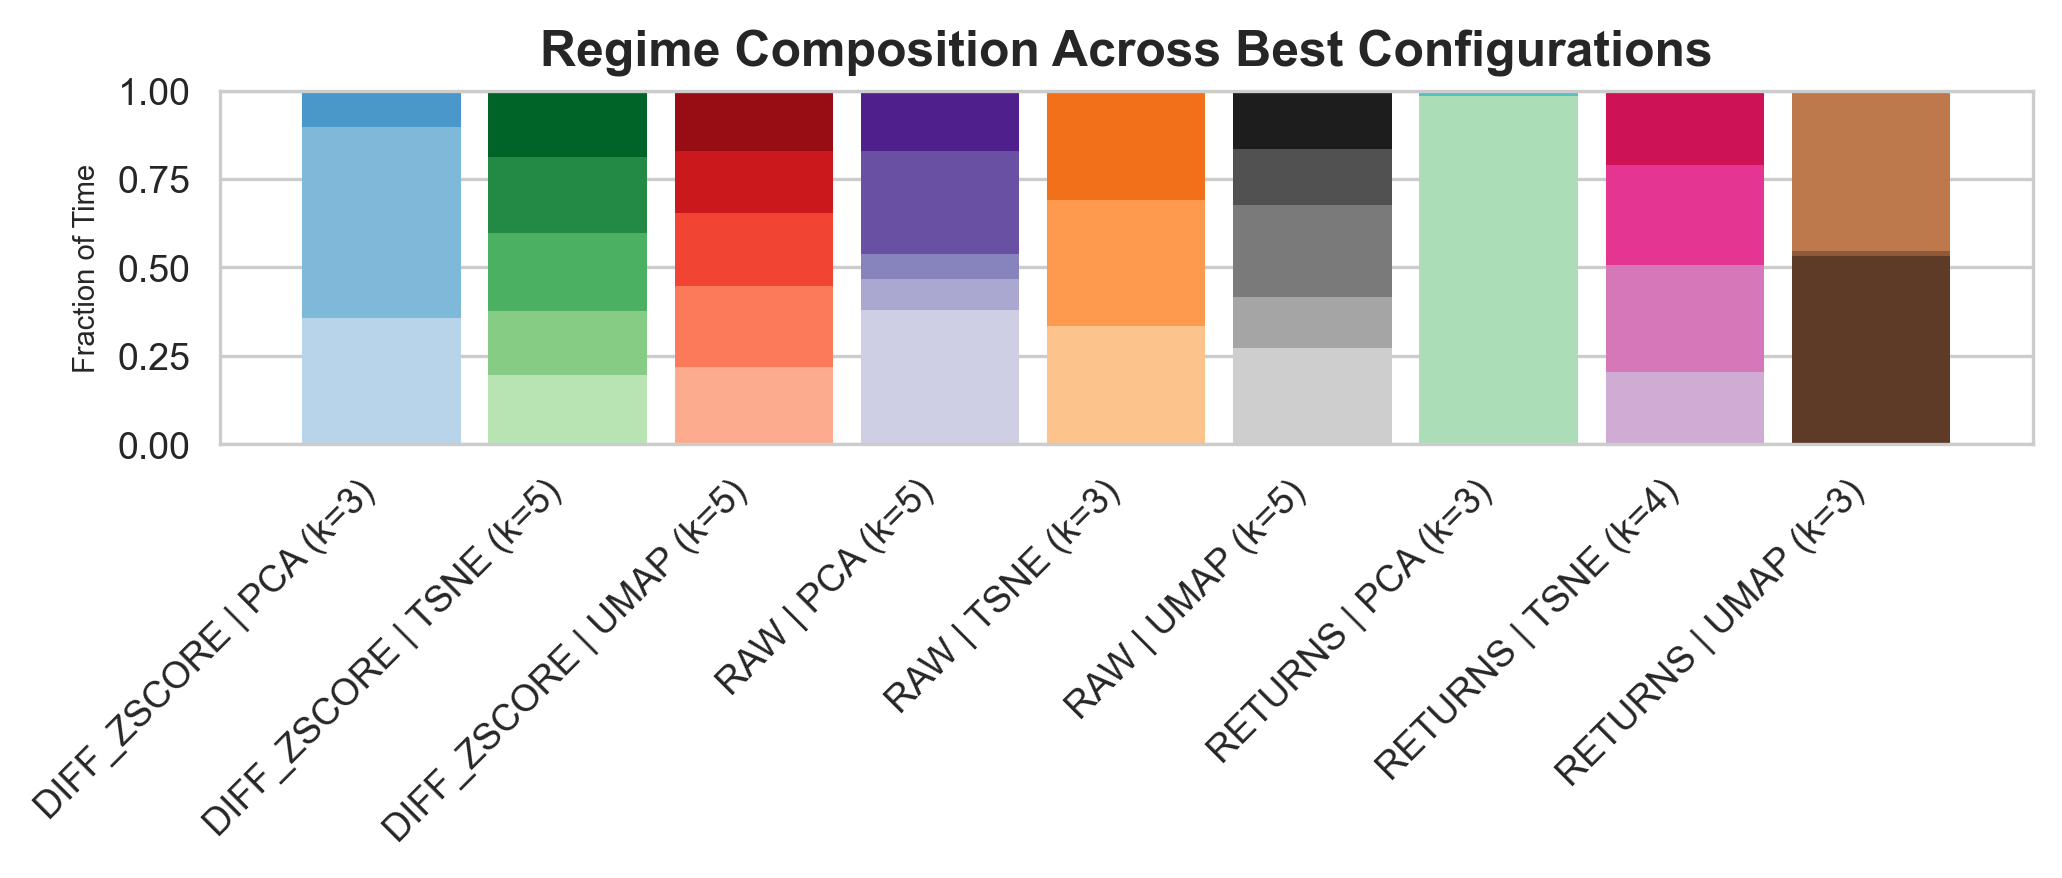

In [91]:
plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

fig, ax = plt.subplots(figsize=(7, 3))

x = np.arange(len(configs))
bar_width = 0.85

cmaps = [
    cm.Blues, cm.Greens, cm.Reds, cm.Purples,
    cm.Oranges, cm.Greys, cm.YlGnBu, cm.PuRd, cm.copper
]

for i, config in enumerate(configs):
    bottom = 0.0
    values = pivot.loc[config].values

    cmap = cmaps[i % len(cmaps)]
    colors = cmap(np.linspace(0.3, 0.9, len(values)))

    for val, color in zip(values, colors):
        if val > 0:
            ax.bar(
                x[i],
                val,
                bottom=bottom,
                width=bar_width,
                color=color,
                edgecolor="none"
            )
            bottom += val

ax.set_xticks(x)
ax.set_xticklabels(
    configs,
    rotation=45,
    ha="right",
    fontsize=9
)

ax.set_ylabel("Fraction of Time", fontsize=7)
ax.set_title(
    "Regime Composition Across Best Configurations",
    fontsize=12,
    fontweight="bold"
)

ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig(media_path + "/proportion_regime.png", dpi=300, bbox_inches="tight")
plt.show()


## Temporal Analysis

In [105]:
# ensure date is datetime
df = cached_embeddings_df.copy()
df["date"] = pd.to_datetime(df["date"])

# pick your "best" configuration (example)
best = (
    df
    .query("preprocessing == 'returns' and dimred == 'pca' and k == 3")
    .sort_values("date")
)

# collapse to daily regime label
regime_ts = (
    best[["date", "label"]]
    .set_index("date")
    .rename(columns={"label": "Regime"})
)

def get_regime_ts(df, preprocessing, dimred, k):
    out = (
        df
        .query(
            "preprocessing == @preprocessing and "
            "dimred == @dimred and "
            "k == @k"
        )
        .sort_values("date")
        .loc[:, ["date", "label"]]
        .copy()
    )
    out["date"] = pd.to_datetime(out["date"])
    return out.set_index("date").rename(columns={"label": "Regime"})

In [ ]:
# fig, axes = plt.subplots(
#     3, 3,
#     figsize=(16, 6),
#     sharex=True,
#     sharey=True
# )

# for ax, cfg in zip(axes.flatten(), best_configs):
#     ts = get_regime_ts(cached_embeddings_df, **cfg)

#     ax.scatter(
#         ts.index,
#         ts["Regime"],
#         c=ts["Regime"],
#         cmap="tab10",
#         s=4,
#         alpha=0.9
#     )

#     title = f"{cfg['dimred'].upper()} (k={cfg['k']})"
#     ax.set_title(title, fontsize=9)

#     ax.grid(alpha=0.15)

# # Row labels (preprocessing)
# axes[0, 0].set_ylabel("RAW", fontsize=10, fontweight="bold")
# axes[1, 0].set_ylabel("DIFF ZSCORE", fontsize=10, fontweight="bold")
# axes[2, 0].set_ylabel("RETURNS", fontsize=10, fontweight="bold")

# # Shared labels
# fig.text(0.5, 0.04, "Date", ha="center")
# fig.text(0.04, 0.5, "Regime", va="center", rotation="vertical")

# fig.suptitle(
#     "Temporal Evolution of Discovered Regimes Across Best Configurations",
#     fontsize=12,
#     fontweight="bold",
#     y=1.02
# )

# plt.tight_layout()
# plt.show()


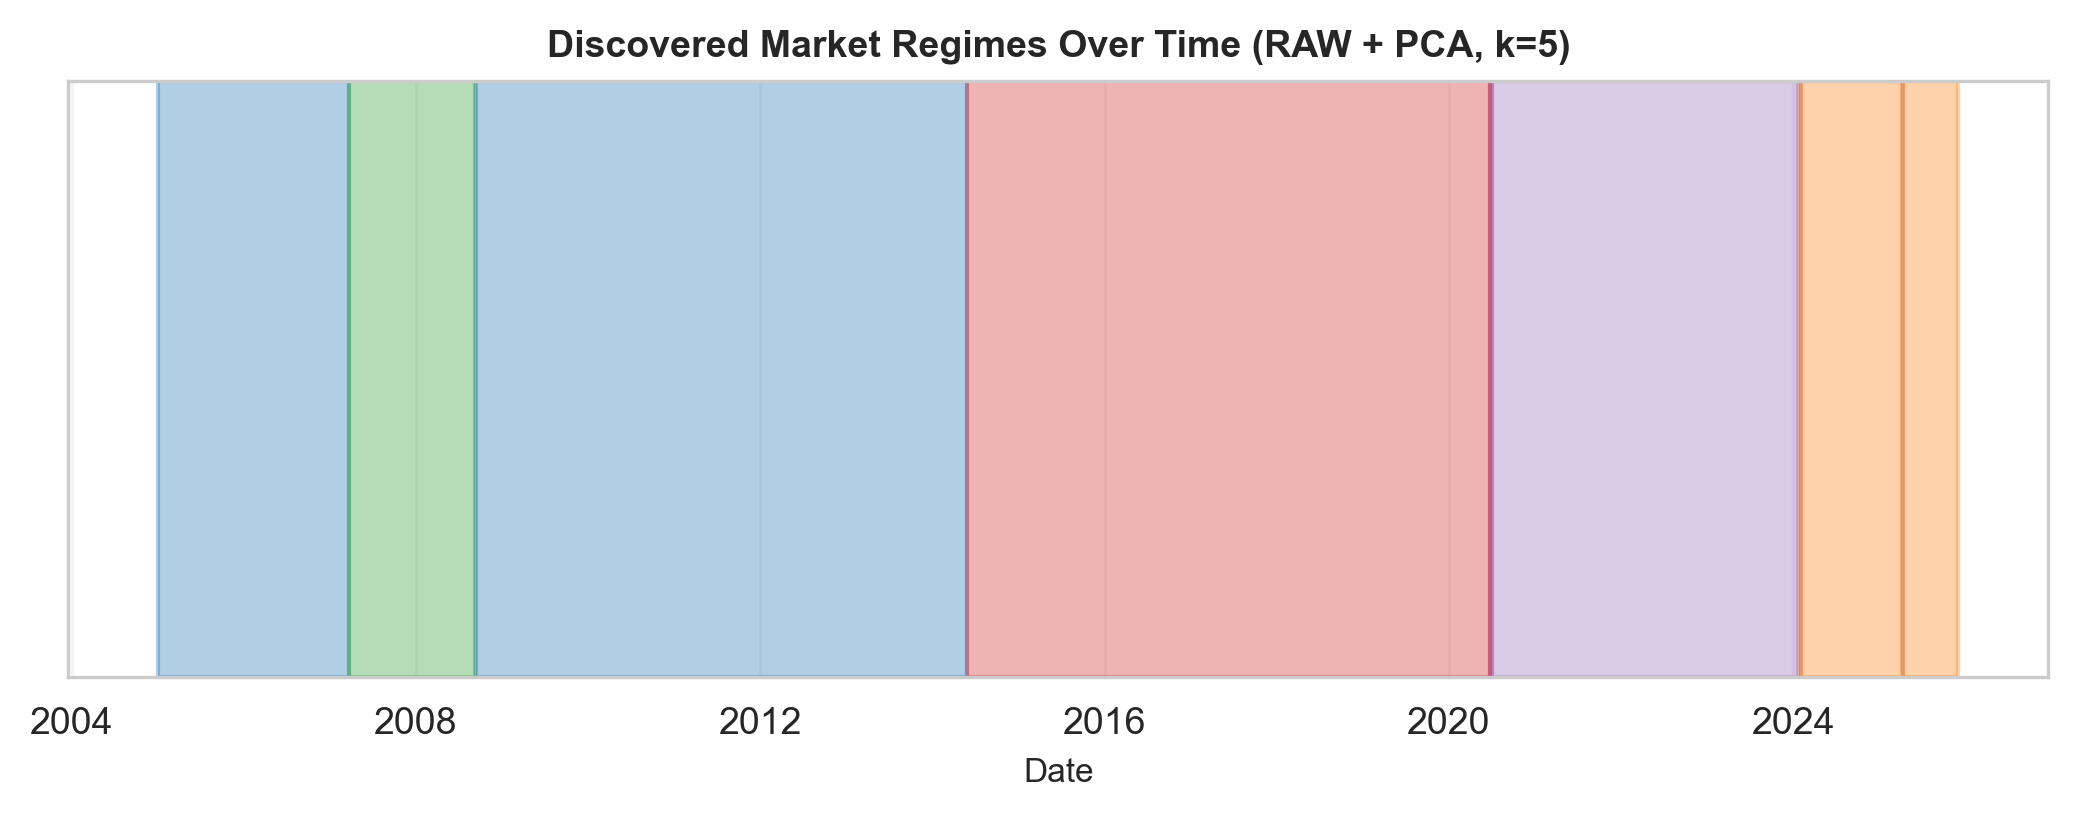

In [ ]:
# PCA on RAW only
cfg = dict(preprocessing="raw", dimred="pca", k=5)
ts = get_regime_ts(cached_embeddings_df, **cfg)

# identify regime runs
runs = ts["Regime"].ne(ts["Regime"].shift()).cumsum()

fig, ax = plt.subplots(figsize=(7, 2.8))

for _, g in ts.groupby(runs):
    ax.axvspan(
        g.index.min(),
        g.index.max(),
        color=plt.cm.tab10(g["Regime"].iloc[0]),
        alpha=0.35
    )

ax.set_title("Discovered Market Regimes Over Time (RAW + PCA, k=5)",
             fontsize=9, fontweight="bold")
ax.set_xlabel("Date", fontsize=8)
ax.set_yticks([])

ax.grid(axis="x", alpha=0.2)

plt.tight_layout()
plt.savefig("temporal_regime_blocks.png")
plt.show()
